<a href="https://colab.research.google.com/github/MartinaCecchetto/ToxicCommentClassification/blob/main/code/toxic_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***TOXIC COMMENT CLASSIFICATION***

**Advance Machine Learning, a.a. 2020-21** 

Roberta Bensi - 861555 - r.bensi@campus.unimib.it

Martina Roberta Cecchetto - 852566 - m.cecchetto2@campus.unimib.it 

Giuseppe Monea - 850432 - g.monea@campus.unimib.it


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D, MaxPooling1D, GRU
from keras.metrics import Precision, Recall
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD, Adamax
import sklearn 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Recall, Precision, AUC
import regex as re
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random as python_random
import pandas as pd
!pip install contractions
import contractions
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from nltk.stem import WordNetLemmatizer 
from sklearn.utils import class_weight
!pip install textaugment
from textaugment import EDA
nltk.download('wordnet')
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(123)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(123)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(1234)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(1234) # tensorflow 2.x
# tf.set_random_seed(seed_value) # tensorflow 1.x

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from google.colab import drive
import os 
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/AML/AML Progetto/')
data_folder = "data/"

Mounted at /content/drive


# **TRAIN UPLOAD**

In [ ]:
train=pd.read_csv(data_folder+ "train.csv")
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


Controllo di quali sono i commenti che non presentano tossicità ma presentano una sua sottocategoria.

In [ ]:
train.loc[(train.toxic==0) & ((train.severe_toxic==1) | (train.obscene==1) | (train.threat==1) | (train.insult==1) | (train.identity_hate==1))]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
179,006d11791d76b9f3,"REPLY ABOVE:\nThat was me, loser. The UN defin...",0,0,0,0,1,0
527,01625cc84c6ef15b,How do you know he is dead. Its just his plan...,0,0,1,0,0,0
662,01ccf4d20d31dfbe,Hebrew Name of Lydia \nAppologies to Til Eulen...,0,0,0,0,1,0
1232,0350c82d1f207e0e,Bleh. I'm all out of ideas. Is there really so...,0,0,1,0,0,0
1351,03aec26f9b6f9ba3,"""\n\n Stop. \n\nStop redirecting the Teddygodz...",0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
158615,f0b46600c7cf2515,"""""""And at least Castro was trying to liberate ...",0,0,1,0,1,0
158793,f3d62179cdb93e58,"Hey FayssalFag, will you ever get a life offli...",0,0,1,0,1,0
158933,f60a9bd97d717630,Administratore: I need your help to stop DIREK...,0,0,0,0,1,0
159103,f896893958bb1cec,"OH DEAR OH DEAR, HOW FUKIN SAD. I WILL REGRET ...",0,0,1,0,0,0


Viene definita una funzione che sostituisca con 1 in tossicità se almeno una sottocategoria è presente.

In [ ]:
def toxic_fixed(toxic,severe_toxic,obscene,threat,insult,identity_hate):
  if ((toxic==0) & ((severe_toxic==1) | (obscene==1) | (threat==1) | (insult==1) | (identity_hate==1))):
    return 1 
  return toxic

In [ ]:
train['toxic']=train.apply(lambda x: toxic_fixed(x['toxic'],x['severe_toxic'],x['obscene'],x['threat'],
                                                 x['insult'],x['identity_hate']), axis=1)

Viene definita una funzione per la pulizia del testo.

In [ ]:
def clean_comment(comment):
  new_comment=comment.apply(lambda x: x.lower())
  new_comment=new_comment.apply(lambda x: contractions.fix(x))
  new_comment=new_comment.str.replace("[^a-zA-Z#]", " ")
  new_comment=new_comment.str.replace("I", "i")
  new_comment=new_comment.apply(lambda mystring: ' '.join(mystring.split()))
  return new_comment

In [ ]:
train['clean_comment']=clean_comment(train['comment_text'])
print(train['clean_comment'])

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i am s...
2         hey man i am really not trying to edit war it ...
3         more i can not make any real suggestions on im...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm there is no actual article for pro...
159569    and it looks like it was actually you who put ...
159570    and i really do not think you understand i cam...
Name: clean_comment, Length: 159571, dtype: object


##Rimozione stop words

Si rimuovono le stop words.

In [ ]:
stop=set(stopwords.words('english'))
train['clean_comment_wo_stopwords']=train['clean_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
train['clean_comment_wo_stopwords']

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         make real suggestions improvement wondered sec...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm actual article prostitution ring c...
159569    looks like actually put speedy first version d...
159570    really think understand came idea bad right aw...
Name: clean_comment_wo_stopwords, Length: 159571, dtype: object

## Subsampling

Si effettua la tecnica del subsampling, prendendo tutti i commenti con tossicità e effettuando un sampling della stessa numerosità di commenti non tossici.

In [ ]:
sub_train=pd.DataFrame()
sub_train=train.loc[(train.toxic==1)]
l=len(sub_train)
row_non_toxic=train.loc[(train.toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)]
row_non_toxic= row_non_toxic.sample(l)
sub_train=sub_train.append(row_non_toxic).sample(frac=1)

## Data augmentation

Si effettua la tecnica di data augmentation.

In [ ]:
print(len(train.loc[train.toxic==0]))
print(len(train.loc[train.toxic==1]))
print(len(train.loc[train.severe_toxic==1]))
print(len(train.loc[train.obscene==1]))
print(len(train.loc[train.threat==1]))
print(len(train.loc[train.insult==1]))
print(len(train.loc[train.identity_hate==1]))



143346
16225
1595
8449
478
7877
1405


Viene definita una funzione che crea tre dataset ciascuno effettuando le seguenti modifiche al dataset originale: sostituzione dei sinonimi, scambio random di due parole (effettuato due volte) e una eliminazione random di parole nella frase (con probabilità dello 0,2).



In [ ]:
def data_augmentation(df, column):
  t = EDA()
  data_augmented_1=df.loc[(df[column]==1)]
  data_augmented_2=df.loc[(df[column]==1)]
  data_augmented_3=df.loc[(df[column]==1)]
  #Synonym Replacement
  data_augmented_1['augmented_text']=data_augmented_1['clean_comment'].apply(lambda x: t.synonym_replacement(x))
  #Random Swap
  data_augmented_2['augmented_text']=data_augmented_2['clean_comment'].apply(lambda x: t.random_swap(x))
  data_augmented_2['augmented_text']=data_augmented_2['augmented_text'].apply(lambda x: t.random_swap(x))
  #Random Deletion
  data_augmented_3['augmented_text']=data_augmented_3['clean_comment'].apply(lambda x: t.random_deletion(x,p=0.2))
  #Unione dei dataset
  data_augmented=pd.DataFrame()
  data_augmented=data_augmented.append(data_augmented_1)
  data_augmented=data_augmented.append(data_augmented_2)
  data_augmented=data_augmented.append(data_augmented_3)
  del data_augmented['clean_comment_wo_stopwords']
  stop=set(stopwords.words('english'))
  data_augmented['clean_comment_wo_stopwords']=data_augmented['augmented_text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop]))
  return data_augmented


Si effettua la data augmentation delle seguenti categorie:
*   toxic
*   severe_toxic
*   identity_hate
*   threat

### toxic

In [ ]:
train_augmented=train
data_augmented=data_augmentation(train_augmented, 'toxic')
train_augmented=train_augmented.append(data_augmented)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
print(len(train_augmented.loc[train_augmented.toxic==0]))
print(len(train_augmented.loc[train_augmented.toxic==1]))
print(len(train_augmented.loc[train_augmented.severe_toxic==1]))
print(len(train_augmented.loc[train_augmented.obscene==1]))
print(len(train_augmented.loc[train_augmented.threat==1]))
print(len(train_augmented.loc[train_augmented.insult==1]))
print(len(train_augmented.loc[train_augmented.identity_hate==1]))

143346
64900
6380
33796
1912
31508
5620


### severe_toxic

In [ ]:
train_augmented=train_augmented.append(data_augmentation(data_augmented, 'severe_toxic'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
print(len(train_augmented.loc[train_augmented.toxic==0]))
print(len(train_augmented.loc[train_augmented.toxic==1]))
print(len(train_augmented.loc[train_augmented.severe_toxic==1]))
print(len(train_augmented.loc[train_augmented.obscene==1]))
print(len(train_augmented.loc[train_augmented.threat==1]))
print(len(train_augmented.loc[train_augmented.insult==1]))
print(len(train_augmented.loc[train_augmented.identity_hate==1]))

143346
79255
20735
47449
2920
43847
8437


### identity_hate

In [ ]:
train_augmented=train_augmented.append(data_augmentation(data_augmented, 'identity_hate'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
print(len(train_augmented.loc[train_augmented.toxic==0]))
print(len(train_augmented.loc[train_augmented.toxic==1]))
print(len(train_augmented.loc[train_augmented.severe_toxic==1]))
print(len(train_augmented.loc[train_augmented.obscene==1]))
print(len(train_augmented.loc[train_augmented.threat==1]))
print(len(train_augmented.loc[train_augmented.insult==1]))
print(len(train_augmented.loc[train_augmented.identity_hate==1]))

143346
91900
23552
56737
3802
54287
21082


### threat

In [ ]:
threat=data_augmentation(data_augmented, 'threat')
train_augmented=train_augmented.append(threat)
train_augmented=train_augmented.append(data_augmentation(threat, 'threat'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
print(len(train_augmented.loc[train_augmented.toxic==0]))
print(len(train_augmented.loc[train_augmented.toxic==1]))
print(len(train_augmented.loc[train_augmented.severe_toxic==1]))
print(len(train_augmented.loc[train_augmented.obscene==1]))
print(len(train_augmented.loc[train_augmented.threat==1]))
print(len(train_augmented.loc[train_augmented.insult==1]))
print(len(train_augmented.loc[train_augmented.identity_hate==1]))

143346
109108
27584
67573
21010
65339
24610


Dataset finale utilizzato per il training, con le sottocategorie aumentate:

In [ ]:
train_augmented

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment,clean_comment_wo_stopwords,augmented_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,explanation edits made username hardcore metal...,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he matches this background colour i am s...,aww matches background colour seemingly stuck ...,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i am really not trying to edit war it ...,hey man really trying edit war guy constantly ...,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can not make any real suggestions on im...,make real suggestions improvement wondered sec...,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,sir hero chance remember page,NaN
...,...,...,...,...,...,...,...,...,...,...,...
157718,e26b106943e02cbf,bitch \nyou are a fucking hore. you suck dick ...,1,0,1,1,1,1,bitch you are a fucking hore you suck dick you...,bitch hore dick big ass hole gay bitch go hell...,bitch you are hore you dick you big ass hole y...
158717,f264b7fb9a4b4f53,stupid head \n\nYOur dumb and you are stupid d...,1,0,1,1,1,0,stupid head your dumb and you are stupid die d...,stupid dumb die die go,stupid your dumb and are die die go
158856,f4dca9e513e0366f,"Hey \n\nhey faggot, are you dead yet? or are y...",1,1,1,1,1,0,hey hey faggot are you dead yet or are you wat...,hey hey faggot yet mom getting raped pigs one ...,hey hey faggot are you yet or are you mom gett...
159029,f780e4f42aa5a344,Death to Musulmans!,1,0,0,1,0,1,death to musulmans,musulmans,to musulmans


##Tokenization

Si effettua la tokenizzazione delle frasi nei due casi (subsampling e data_augmentation)

### Se subsampling

In [ ]:
list_sentences_train = sub_train['clean_comment_wo_stopwords'].fillna("null").values
tokenizer_subsampling = text.Tokenizer(num_words=60000)
tokenizer_subsampling.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer_subsampling.texts_to_sequences(list_sentences_train)
average = sum(len(word) for word in list_tokenized_train) / len(list_tokenized_train)
print(average)
x_train_subsampling = sequence.pad_sequences(list_tokenized_train, maxlen=150)

31.824560862865948


### Se data augmentation

In [ ]:
train_augmented=train_augmented.sample(frac=1)
train_augmented=train_augmented.reset_index(drop=True)
list_sentences_train = train_augmented['clean_comment_wo_stopwords'].fillna("null").values
tokenizer_data_augmentation= text.Tokenizer(num_words=60000)
tokenizer_data_augmentation.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer_data_augmentation.texts_to_sequences(list_sentences_train)
average = sum(len(word) for word in list_tokenized_train) / len(list_tokenized_train)
print(average)
x_train_data_augmentation = sequence.pad_sequences(list_tokenized_train, maxlen=150)

32.40838727055226


# **TEST UPLOAD**

Si carica il test rimuovendo successivamente i commenti che presentano -1 come valori ad ogni label.

In [ ]:
test=pd.read_csv(data_folder+ "test.csv")
test_labels=pd.read_csv(data_folder+ "test_labels.csv")
print(test)
print(test_labels)
test_labels=test_labels.loc[(test_labels.toxic==0) | (test_labels.toxic==1)]

                      id                                       comment_text
0       00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1       0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2       00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3       00017563c3f7919a  :If you have a look back at the source, the in...
4       00017695ad8997eb          I don't anonymously edit articles at all.
...                  ...                                                ...
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...
153160  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...
153161  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...
153162  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...
153163  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...

[153164 rows x 2 columns]
                      id  toxic  severe_toxic  ...  threat  i

Si effettua la pulizia dei commenti.

In [ ]:
test=test[test.id.isin(test_labels.id)].reset_index()
test['clean_comment'] = clean_comment(test['comment_text'])
test

,index,id,comment_text,clean_comment
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank you for understanding i think very highl...
1,7,000247e83dcc1211,:Dear god this site is horrible.,dear god this site is horrible
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",somebody will invariably try to add religion r...
3,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",it says it right there that it is a type the t...
4,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",before adding a new product to the list make s...
...,...,...,...,...
63973,153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",jerome i see you never got around to this i am...
63974,153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,lucky bastard http wikimediafoundation org wik...
63975,153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,shame on you all you want to speak about gays ...
63976,153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,mel gibson is a nazi bitch who makes shitty mo...


Vengono rimosse le stop words.

In [ ]:
stop=set(stopwords.words('english'))
test['clean_comment_wo_stopwords']=test['clean_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
test['clean_comment_wo_stopwords']

0        thank understanding think highly would revert ...
1                                   dear god site horrible
2        somebody invariably try add religion really me...
3        says right type type institution needed case t...
4        adding new product list make sure relevant add...
                               ...                        
63973    jerome see never got around surprised looked e...
63974    lucky bastard http wikimediafoundation org wik...
63975                      shame want speak gays romanians
63976    mel gibson nazi bitch makes shitty movies much...
63977    unicorn lair discovery supposedly unicorn lair...
Name: clean_comment_wo_stopwords, Length: 63978, dtype: object

##Tokenization

Anche qui viene effettuata la tokenizzazione nei due casi di tecniche differenti.

##Se subsampling

In [ ]:
list_sentences_test = test['clean_comment_wo_stopwords'].fillna('null').values
list_tokenized_test = tokenizer_subsampling.texts_to_sequences(list_sentences_test)
average = sum(len(word) for word in list_tokenized_test) / len(list_tokenized_test)
print(average)
x_test_subsampling= sequence.pad_sequences(list_tokenized_test, maxlen=150)


30.928522304542188


## Se data augmentation

In [ ]:
list_sentences_test = test['clean_comment_wo_stopwords'].fillna('null').values
list_tokenized_test = tokenizer_data_augmentation.texts_to_sequences(list_sentences_test)
average = sum(len(word) for word in list_tokenized_test) / len(list_tokenized_test)
print(average)
x_test_data_augmentation= sequence.pad_sequences(list_tokenized_test, maxlen=150)


31.297836756385006


#MODELLI Multi-label

In [ ]:
y_test=test_labels[test_labels.columns[1:]].values

## y subsambling

In [ ]:
y_train_subsampling=sub_train[sub_train.columns[2:8]].values

##y data augmentation

In [ ]:
y_train_data_augmentation=train_augmented[train_augmented.columns[2:8]].values

##LSTM

Definizione del modello LSTM 

###Se subsampling

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=60000, output_dim=128, input_length=150))
model_LSTM.add(Bidirectional(LSTM(128,dropout=0.2)))
model_LSTM.add(Dense(6, activation="sigmoid"))
model_LSTM.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 150, 128)          7680000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 1542      
Total params: 7,944,710
Trainable params: 7,944,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=Adamax(learning_rate=1e-3)
model_LSTM.compile(loss="binary_crossentropy",optimizer= optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history1 = model_LSTM.fit(x_train_subsampling, y_train_subsampling, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping], )

Epoch 1/20
203/203 [==============================] - 11s 41ms/step - loss: 0.4306 - precision: 0.5115 - recall: 0.2702 - auc: 0.7647 - val_loss: 0.2907 - val_precision: 0.7278 - val_recall: 0.5782 - val_auc: 0.9059
Epoch 2/20
203/203 [==============================] - 7s 36ms/step - loss: 0.2652 - precision: 0.7912 - recall: 0.5673 - auc: 0.9177 - val_loss: 0.2325 - val_precision: 0.7895 - val_recall: 0.6723 - val_auc: 0.9365
Epoch 3/20
203/203 [==============================] - 7s 36ms/step - loss: 0.2186 - precision: 0.8168 - recall: 0.6750 - auc: 0.9440 - val_loss: 0.2150 - val_precision: 0.8466 - val_recall: 0.6625 - val_auc: 0.9452
Epoch 4/20
203/203 [==============================] - 7s 36ms/step - loss: 0.2009 - precision: 0.8407 - recall: 0.7069 - auc: 0.9530 - val_loss: 0.2041 - val_precision: 0.8474 - val_recall: 0.6917 - val_auc: 0.9503
Epoch 5/20
203/203 [==============================] - 7s 36ms/step - loss: 0.1888 - precision: 0.8510 - recall: 0.7267 - auc: 0.9580 - val_

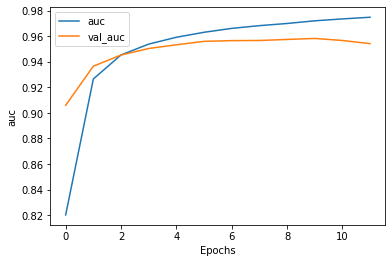

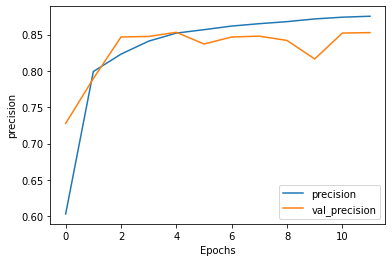

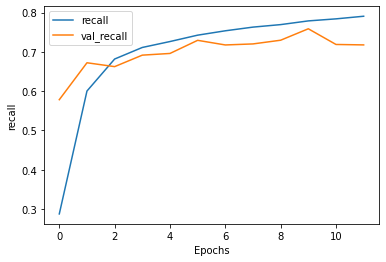

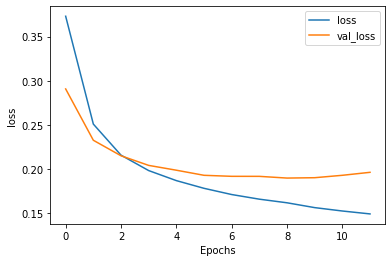

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history1, "auc") 
plot_graphs(history1, "precision") 
plot_graphs(history1, "recall") 
plot_graphs(history1, "loss")


####Valutazione con il test

In [ ]:
y_pred = (model_LSTM.predict(x_test_subsampling) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=test_labels.columns[1:]))

               precision    recall  f1-score   support

        toxic       0.39      0.93      0.55      6090
 severe_toxic       0.44      0.26      0.32       367
      obscene       0.64      0.74      0.68      3691
       threat       0.00      0.00      0.00       211
       insult       0.59      0.60      0.60      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.47      0.73      0.57     14498
    macro avg       0.34      0.42      0.36     14498
 weighted avg       0.48      0.73      0.55     14498
  samples avg       0.08      0.07      0.07     14498



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Se data augmentation

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=60000, output_dim=128, input_length=150))
model_LSTM.add(Bidirectional(LSTM(128, dropout=0.2)))
model_LSTM.add(Dense(6, activation="sigmoid"))
model_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 128)          7680000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 1542      
Total params: 7,944,710
Trainable params: 7,944,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=Adamax(learning_rate=1e-4)
model_LSTM.compile(loss="binary_crossentropy",optimizer= optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history2 = model_LSTM.fit(x_train_data_augmentation, y_train_data_augmentation, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping], )

Epoch 1/20
1578/1578 [==============================] - 59s 35ms/step - loss: 0.4897 - precision: 0.5176 - recall: 0.0635 - auc: 0.6928 - val_loss: 0.3350 - val_precision: 0.7968 - val_recall: 0.4028 - val_auc: 0.8876
Epoch 2/20
1578/1578 [==============================] - 55s 35ms/step - loss: 0.3130 - precision: 0.7871 - recall: 0.5189 - auc: 0.8995 - val_loss: 0.2603 - val_precision: 0.7919 - val_recall: 0.6442 - val_auc: 0.9295
Epoch 3/20
1578/1578 [==============================] - 55s 35ms/step - loss: 0.2550 - precision: 0.8134 - recall: 0.6341 - auc: 0.9314 - val_loss: 0.2361 - val_precision: 0.8105 - val_recall: 0.6796 - val_auc: 0.9421
Epoch 4/20
1578/1578 [==============================] - 55s 35ms/step - loss: 0.2316 - precision: 0.8389 - recall: 0.6630 - auc: 0.9438 - val_loss: 0.2217 - val_precision: 0.8574 - val_recall: 0.6673 - val_auc: 0.9488
Epoch 5/20
1578/1578 [==============================] - 55s 35ms/step - loss: 0.2207 - precision: 0.8510 - recall: 0.6761 - auc:

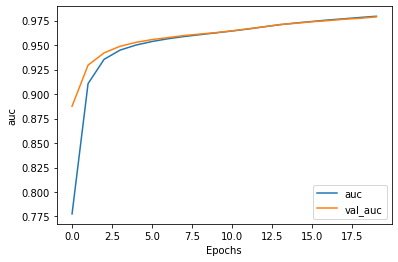

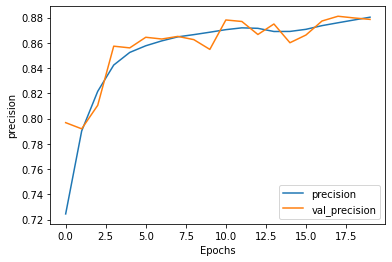

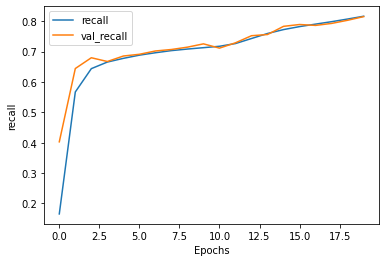

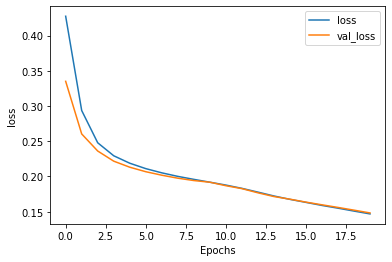

In [ ]:
#plot_graphs(history, "accuracy") 
plot_graphs(history2, "auc") 
plot_graphs(history2, "precision") 
plot_graphs(history2, "recall") 
plot_graphs(history2, "loss")

####Valutazione con il test

In [ ]:
y_pred = (model_LSTM.predict(x_test_data_augmentation) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=test_labels.columns[1:]))

               precision    recall  f1-score   support

        toxic       0.42      0.92      0.57      6090
 severe_toxic       0.27      0.68      0.39       367
      obscene       0.63      0.77      0.69      3691
       threat       0.27      0.67      0.38       211
       insult       0.55      0.68      0.61      3427
identity_hate       0.59      0.24      0.34       712

    micro avg       0.47      0.78      0.59     14498
    macro avg       0.45      0.66      0.50     14498
 weighted avg       0.50      0.78      0.59     14498
  samples avg       0.08      0.08      0.07     14498



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

Definizione del modello CNN

###Se subsampling

In [ ]:
model_cnn= Sequential()
model_cnn.add(Embedding(input_dim=60000, output_dim=124, input_length=150))
model_cnn.add(Conv1D(64, kernel_size=(8), activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=(4)))
model_cnn.add(Conv1D(32, kernel_size=(8), activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=(4)))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation="relu"))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(6, activation="sigmoid"))

model_cnn.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 150, 124)          7440000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 143, 64)           63552     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 35, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 28, 32)            16416     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)              

In [ ]:
optimizer=Adamax(learning_rate=1e-3)
model_cnn.compile(loss="binary_crossentropy",optimizer= optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history3 = model_cnn.fit(x_train_subsampling, y_train_subsampling, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping], )

Epoch 1/20
203/203 [==============================] - 5s 17ms/step - loss: 0.5252 - precision: 0.3285 - recall: 0.3035 - auc: 0.6552 - val_loss: 0.3588 - val_precision: 0.6192 - val_recall: 0.3528 - val_auc: 0.8478
Epoch 2/20
203/203 [==============================] - 3s 15ms/step - loss: 0.3822 - precision: 0.5404 - recall: 0.3484 - auc: 0.8123 - val_loss: 0.3191 - val_precision: 0.6952 - val_recall: 0.3928 - val_auc: 0.8816
Epoch 3/20
203/203 [==============================] - 3s 15ms/step - loss: 0.3297 - precision: 0.6397 - recall: 0.4556 - auc: 0.8680 - val_loss: 0.3006 - val_precision: 0.6859 - val_recall: 0.5526 - val_auc: 0.8977
Epoch 4/20
203/203 [==============================] - 3s 15ms/step - loss: 0.3001 - precision: 0.6920 - recall: 0.5466 - auc: 0.8952 - val_loss: 0.2761 - val_precision: 0.7646 - val_recall: 0.5606 - val_auc: 0.9122
Epoch 5/20
203/203 [==============================] - 3s 15ms/step - loss: 0.2697 - precision: 0.7396 - recall: 0.5987 - auc: 0.9152 - val_l

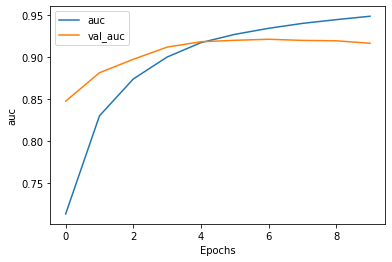

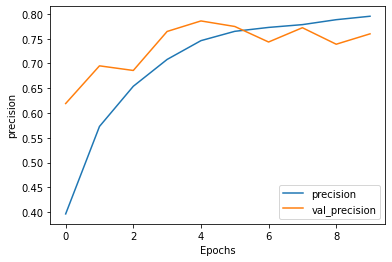

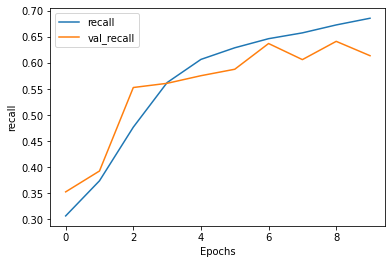

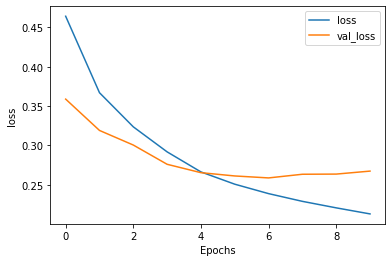

In [ ]:
plot_graphs(history3, "auc") 
plot_graphs(history3, "precision") 
plot_graphs(history3, "recall") 
plot_graphs(history3, "loss")

#### Valutazione con il test

In [ ]:
y_pred = (model_cnn.predict(x_test_subsampling) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=test_labels.columns[1:]))

               precision    recall  f1-score   support

        toxic       0.25      0.83      0.39      6090
 severe_toxic       0.49      0.17      0.25       367
      obscene       0.46      0.53      0.49      3691
       threat       0.00      0.00      0.00       211
       insult       0.45      0.48      0.47      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.31      0.60      0.41     14498
    macro avg       0.28      0.33      0.27     14498
 weighted avg       0.34      0.60      0.40     14498
  samples avg       0.07      0.06      0.06     14498



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Se data augmentation

In [ ]:
model_cnn= Sequential()
model_cnn.add(Embedding(input_dim=60000, output_dim=124, input_length=150))
model_cnn.add(Conv1D(64, kernel_size=(8), activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=(4)))
model_cnn.add(Conv1D(32, kernel_size=(8), activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=(4)))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation="relu"))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(6, activation="sigmoid"))

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 124)          7440000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 143, 64)           63552     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 35, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 32)            16416     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

In [ ]:
optimizer=Adamax(learning_rate=1e-4)
model_cnn.compile(loss="binary_crossentropy",optimizer= optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history4 = model_cnn.fit(x_train_data_augmentation, y_train_data_augmentation, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping], )

Epoch 1/20
1578/1578 [==============================] - 22s 13ms/step - loss: 0.5488 - precision: 0.3327 - recall: 0.1976 - auc: 0.6148 - val_loss: 0.4416 - val_precision: 0.6077 - val_recall: 0.1313 - val_auc: 0.7629
Epoch 2/20
1578/1578 [==============================] - 21s 13ms/step - loss: 0.4508 - precision: 0.4982 - recall: 0.1994 - auc: 0.7416 - val_loss: 0.3721 - val_precision: 0.6975 - val_recall: 0.2831 - val_auc: 0.8523
Epoch 3/20
1578/1578 [==============================] - 21s 13ms/step - loss: 0.3770 - precision: 0.6620 - recall: 0.3712 - auc: 0.8403 - val_loss: 0.3207 - val_precision: 0.7863 - val_recall: 0.4579 - val_auc: 0.8931
Epoch 4/20
1578/1578 [==============================] - 21s 13ms/step - loss: 0.3271 - precision: 0.7358 - recall: 0.4958 - auc: 0.8844 - val_loss: 0.2902 - val_precision: 0.7827 - val_recall: 0.5556 - val_auc: 0.9117
Epoch 5/20
1578/1578 [==============================] - 21s 13ms/step - loss: 0.2985 - precision: 0.7664 - recall: 0.5527 - auc:

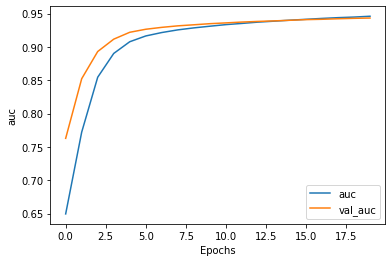

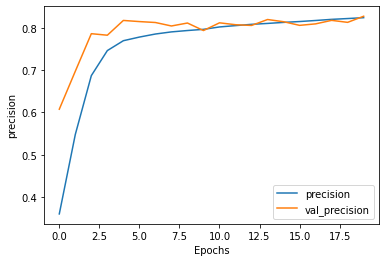

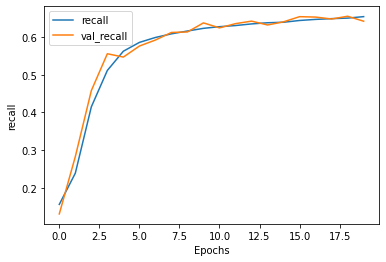

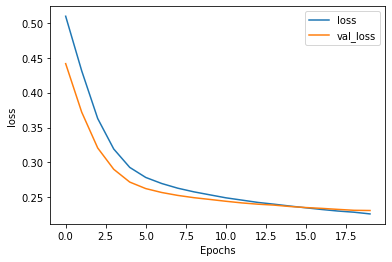

In [ ]:
plot_graphs(history4, "auc") 
plot_graphs(history4, "precision") 
plot_graphs(history4, "recall") 
plot_graphs(history4, "loss")

####Valutazione con il test

In [ ]:
y_pred = (model_cnn.predict(x_test_data_augmentation) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=test_labels.columns[1:]))

               precision    recall  f1-score   support

        toxic       0.30      0.78      0.43      6090
 severe_toxic       0.29      0.53      0.38       367
      obscene       0.52      0.50      0.51      3691
       threat       0.11      0.00      0.01       211
       insult       0.48      0.46      0.47      3427
identity_hate       0.48      0.02      0.04       712

    micro avg       0.35      0.58      0.44     14498
    macro avg       0.36      0.38      0.31     14498
 weighted avg       0.40      0.58      0.43     14498
  samples avg       0.07      0.06      0.06     14498



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##GRU

Definizione del modello GRU

###Se subsampling

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=60000, output_dim=64,input_length=150))
model_gru.add(Bidirectional((GRU(128, dropout=0.2))))
model_gru.add(Dense(6, activation="sigmoid"))
model_gru.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 150, 64)           3840000   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 256)               148992    
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 1542      
Total params: 3,990,534
Trainable params: 3,990,534
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=Adamax(learning_rate=1e-3)
model_gru.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history5 = model_gru.fit(x_train_subsampling, y_train_subsampling, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/20
203/203 [==============================] - 10s 31ms/step - loss: 0.4523 - precision: 0.4974 - recall: 0.3217 - auc: 0.7598 - val_loss: 0.2713 - val_precision: 0.7930 - val_recall: 0.5619 - val_auc: 0.9172
Epoch 2/20
203/203 [==============================] - 5s 27ms/step - loss: 0.2499 - precision: 0.8002 - recall: 0.6059 - auc: 0.9267 - val_loss: 0.2215 - val_precision: 0.8416 - val_recall: 0.6552 - val_auc: 0.9412
Epoch 3/20
203/203 [==============================] - 5s 27ms/step - loss: 0.2095 - precision: 0.8258 - recall: 0.6869 - auc: 0.9477 - val_loss: 0.2071 - val_precision: 0.8297 - val_recall: 0.7014 - val_auc: 0.9483
Epoch 4/20
203/203 [==============================] - 5s 27ms/step - loss: 0.1969 - precision: 0.8397 - recall: 0.7197 - auc: 0.9544 - val_loss: 0.2014 - val_precision: 0.8490 - val_recall: 0.6964 - val_auc: 0.9515
Epoch 5/20
203/203 [==============================] - 5s 27ms/step - loss: 0.1887 - precision: 0.8400 - recall: 0.7335 - auc: 0.9580 - val_

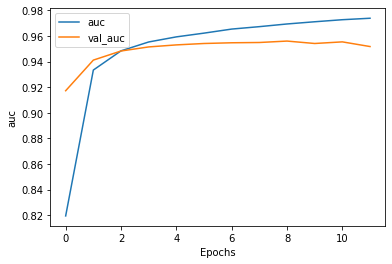

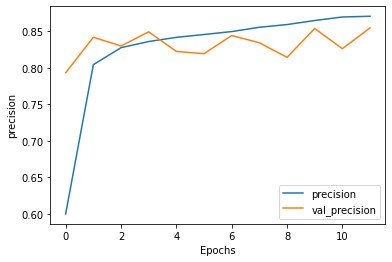

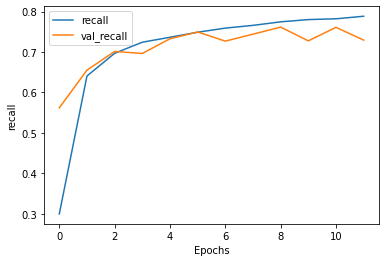

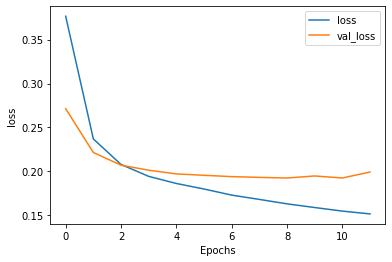

In [ ]:
plot_graphs(history5, "auc") 
plot_graphs(history5, "precision") 
plot_graphs(history5, "recall") 
plot_graphs(history5, "loss")

####Valutazione con il test

In [ ]:
y_pred = (model_gru.predict(x_test_subsampling) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=test_labels.columns[1:]))

               precision    recall  f1-score   support

        toxic       0.38      0.93      0.54      6090
 severe_toxic       0.40      0.27      0.32       367
      obscene       0.61      0.75      0.68      3691
       threat       0.00      0.00      0.00       211
       insult       0.57      0.60      0.59      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.46      0.73      0.56     14498
    macro avg       0.33      0.43      0.36     14498
 weighted avg       0.46      0.73      0.55     14498
  samples avg       0.08      0.07      0.07     14498



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Se data augmentation

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=60000, output_dim=64, input_length=150))
model_gru.add(Bidirectional((GRU(128))))
model_gru.add(Dense(6, activation="sigmoid"))
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 64)           3840000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               148992    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 3,990,534
Trainable params: 3,990,534
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=Adamax(learning_rate=1e-4)
model_gru.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history6 = model_gru.fit(x_train_data_augmentation, y_train_data_augmentation, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/20
1578/1578 [==============================] - 45s 27ms/step - loss: 0.4985 - precision: 0.5104 - recall: 0.0545 - auc: 0.6886 - val_loss: 0.3152 - val_precision: 0.8409 - val_recall: 0.4646 - val_auc: 0.9036
Epoch 2/20
1578/1578 [==============================] - 41s 26ms/step - loss: 0.2996 - precision: 0.8166 - recall: 0.5338 - auc: 0.9084 - val_loss: 0.2621 - val_precision: 0.8319 - val_recall: 0.6048 - val_auc: 0.9286
Epoch 3/20
1578/1578 [==============================] - 41s 26ms/step - loss: 0.2625 - precision: 0.8057 - recall: 0.6280 - auc: 0.9270 - val_loss: 0.2441 - val_precision: 0.8329 - val_recall: 0.6461 - val_auc: 0.9376
Epoch 4/20
1578/1578 [==============================] - 42s 26ms/step - loss: 0.2441 - precision: 0.8231 - recall: 0.6525 - auc: 0.9371 - val_loss: 0.2327 - val_precision: 0.8383 - val_recall: 0.6654 - val_auc: 0.9431
Epoch 5/20
1578/1578 [==============================] - 41s 26ms/step - loss: 0.2339 - precision: 0.8354 - recall: 0.6669 - auc:

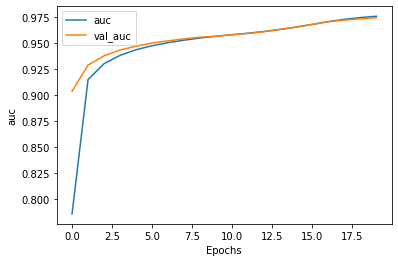

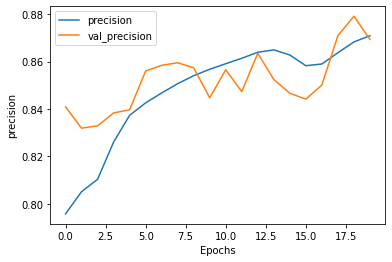

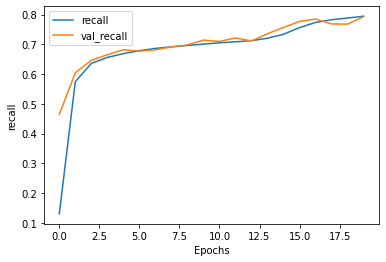

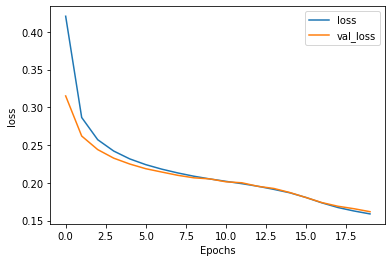

In [ ]:
plot_graphs(history6, "auc") 
plot_graphs(history6, "precision") 
plot_graphs(history6, "recall") 
plot_graphs(history6, "loss")

####Valutazione con il test

In [ ]:
y_pred = (model_gru.predict(x_test_data_augmentation) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=test_labels.columns[1:]))

               precision    recall  f1-score   support

        toxic       0.44      0.91      0.59      6090
 severe_toxic       0.29      0.62      0.40       367
      obscene       0.60      0.78      0.68      3691
       threat       0.22      0.66      0.34       211
       insult       0.52      0.67      0.58      3427
identity_hate       0.45      0.11      0.17       712

    micro avg       0.47      0.77      0.59     14498
    macro avg       0.42      0.62      0.46     14498
 weighted avg       0.49      0.77      0.58     14498
  samples avg       0.08      0.07      0.07     14498



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#MODELLO Binary + Multilabel

##Modello BINARY

Per il problema binario viene estratta soltanto la colonna toxic

In [ ]:
y_train_binary=train_augmented[train_augmented.columns[2]].values

Definizione del modello

In [ ]:
model_LSTM_binary = Sequential()
model_LSTM_binary.add(Embedding(input_dim=60000, output_dim=128,input_length=150))
model_LSTM_binary.add(Bidirectional((LSTM(128, dropout=0.2))))
model_LSTM_binary.add(Dense(1, activation="sigmoid"))
model_LSTM_binary.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 150, 128)          7680000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 7,943,425
Trainable params: 7,943,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=Adamax(learning_rate=1e-4)
model_LSTM_binary.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy','Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history7 = model_LSTM_binary.fit(x_train_data_augmentation, y_train_binary, epochs=num_epochs, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/20
1578/1578 [==============================] - 59s 36ms/step - loss: 0.6046 - accuracy: 0.6630 - precision: 0.6646 - recall: 0.4417 - auc: 0.7175 - val_loss: 0.3690 - val_accuracy: 0.8465 - val_precision: 0.7923 - val_recall: 0.8714 - val_auc: 0.9259
Epoch 2/20
1578/1578 [==============================] - 56s 35ms/step - loss: 0.3417 - accuracy: 0.8678 - precision: 0.8688 - recall: 0.8179 - auc: 0.9312 - val_loss: 0.2804 - val_accuracy: 0.8882 - val_precision: 0.8547 - val_recall: 0.8914 - val_auc: 0.9537
Epoch 3/20
1578/1578 [==============================] - 56s 35ms/step - loss: 0.2626 - accuracy: 0.8962 - precision: 0.9060 - recall: 0.8472 - auc: 0.9570 - val_loss: 0.2299 - val_accuracy: 0.9109 - val_precision: 0.9064 - val_recall: 0.8840 - val_auc: 0.9671
Epoch 4/20
1578/1578 [==============================] - 56s 35ms/step - loss: 0.2231 - accuracy: 0.9111 - precision: 0.9195 - recall: 0.8707 - auc: 0.9686 - val_loss: 0.2079 - val_accuracy: 0.9173 - val_precision: 0.9420

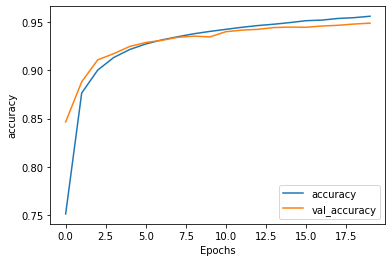

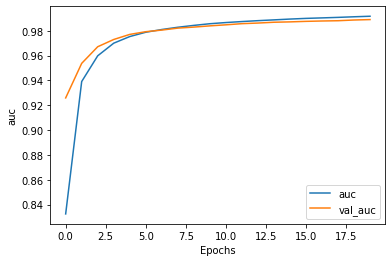

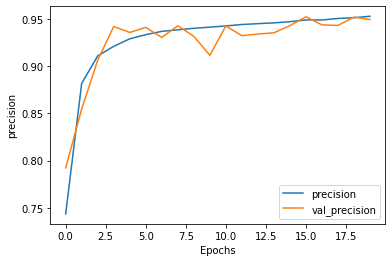

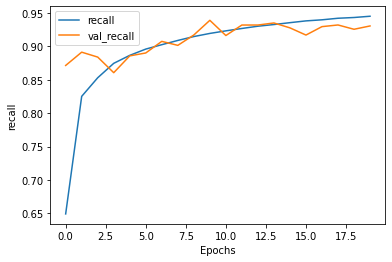

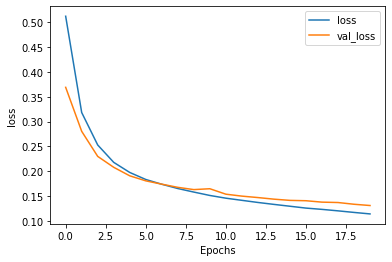

In [ ]:
plot_graphs(history7, "accuracy") 
plot_graphs(history7, "auc") 
plot_graphs(history7, "precision") 
plot_graphs(history7, "recall") 
plot_graphs(history7, "loss")

###Valutazione con il test

In [ ]:
y_test_binary=test_labels['toxic']

In [ ]:
y_pred_binary = (model_LSTM_binary.predict(x_test_data_augmentation) > 0.5).astype("int32")
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     57888
           1       0.43      0.92      0.59      6090

    accuracy                           0.88     63978
   macro avg       0.71      0.90      0.76     63978
weighted avg       0.94      0.88      0.90     63978



##Modello Multilabel

Definizione del modello multilabel nel caso in cui sia già stata riscontrata la presenza di tossicità nel commento.

In [ ]:
test_labels_toxic=test_labels.loc[(test_labels.toxic==1)]

In [ ]:
test_toxic=test[test.id.isin(test_labels_toxic.id)].reset_index()


Tokenizzazione train

In [ ]:
train_augmented_toxic=train_augmented.loc[train_augmented.toxic==1]
list_sentences_train = train_augmented_toxic['clean_comment_wo_stopwords'].fillna("null").values
tokenizer_toxic= text.Tokenizer(num_words=60000)
tokenizer_toxic.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer_toxic.texts_to_sequences(list_sentences_train)
average = sum(len(word) for word in list_tokenized_train) / len(list_tokenized_train)
print(average)
x_train_toxic = sequence.pad_sequences(list_tokenized_train, maxlen=150)

29.902775231880337


Tokenizzazione test

In [ ]:
list_sentences_test = test_toxic['clean_comment_wo_stopwords'].fillna('null').values
list_tokenized_test = tokenizer_toxic.texts_to_sequences(list_sentences_test)
average = sum(len(word) for word in list_tokenized_test) / len(list_tokenized_test)
print(average)
x_test_toxic= sequence.pad_sequences(list_tokenized_test, maxlen=150)

21.78045977011494


Definizione del modello

In [ ]:
model_LSTM_toxic = Sequential()
model_LSTM_toxic.add(Embedding(input_dim=60000, output_dim=128,input_length=150))
model_LSTM_toxic.add(Bidirectional((LSTM(128, dropout=0.3))))
model_LSTM_toxic.add(Dense(5, activation="sigmoid"))
model_LSTM_toxic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          7680000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 7,944,453
Trainable params: 7,944,453
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_toxic=train_augmented_toxic[train_augmented_toxic.columns[3:8]].values

In [ ]:
optimizer=Adamax(learning_rate=1e-3)
model_LSTM_toxic.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['Precision', 'Recall', 'AUC'])
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history8 = model_LSTM_toxic.fit(x_train_toxic, y_train_toxic, epochs=num_epochs, batch_size=124, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/20
704/704 [==============================] - 28s 36ms/step - loss: 0.4067 - precision: 0.8258 - recall: 0.6441 - auc: 0.8845 - val_loss: 0.3245 - val_precision: 0.8446 - val_recall: 0.7674 - val_auc: 0.9314
Epoch 2/20
704/704 [==============================] - 24s 34ms/step - loss: 0.3065 - precision: 0.8489 - recall: 0.7861 - auc: 0.9392 - val_loss: 0.2783 - val_precision: 0.8859 - val_recall: 0.7753 - val_auc: 0.9524
Epoch 3/20
704/704 [==============================] - 24s 34ms/step - loss: 0.2591 - precision: 0.8662 - recall: 0.8307 - auc: 0.9569 - val_loss: 0.2421 - val_precision: 0.8696 - val_recall: 0.8552 - val_auc: 0.9626
Epoch 4/20
704/704 [==============================] - 24s 34ms/step - loss: 0.2269 - precision: 0.8813 - recall: 0.8608 - auc: 0.9671 - val_loss: 0.2154 - val_precision: 0.8746 - val_recall: 0.8869 - val_auc: 0.9703
Epoch 5/20
704/704 [==============================] - 24s 34ms/step - loss: 0.1998 - precision: 0.8958 - recall: 0.8839 - auc: 0.9745 - 

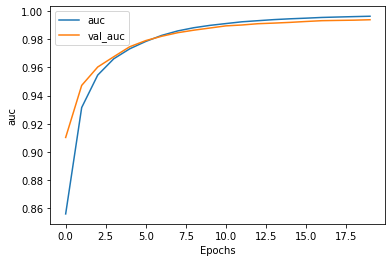

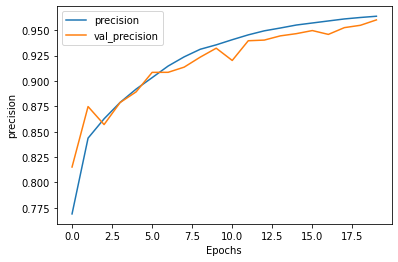

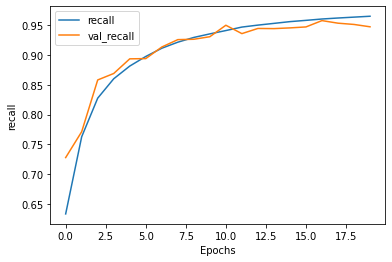

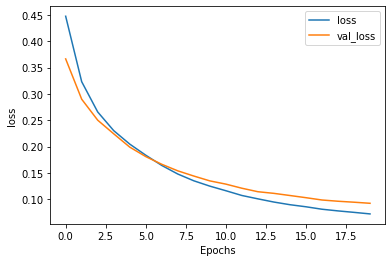

In [ ]:
plot_graphs(history8, "auc") 
plot_graphs(history8, "precision") 
plot_graphs(history8, "recall") 
plot_graphs(history8, "loss")

In [ ]:
y_test_toxic=test_labels_toxic[test_labels_toxic.columns[2:8]].values

In [ ]:
y_pred = (model_LSTM_toxic.predict(x_test_toxic) > 0.5).astype("int32")
print(classification_report(y_test_toxic, y_pred, target_names=test_labels.columns[2:]))

               precision    recall  f1-score   support

 severe_toxic       0.23      0.44      0.30       367
      obscene       0.78      0.76      0.77      3626
       threat       0.46      0.48      0.47       205
       insult       0.70      0.67      0.68      3342
identity_hate       0.60      0.51      0.55       693

    micro avg       0.68      0.68      0.68      8233
    macro avg       0.55      0.57      0.55      8233
 weighted avg       0.70      0.68      0.69      8233
  samples avg       0.49      0.49      0.46      8233



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
